# Validation Set 1.2: diffuPy + PathMe  

In [2]:
import os
import itertools

import time

dir_path = os.path.dirname(os.path.realpath('__file__'))

In [3]:
from openpyxl import load_workbook
from collections import defaultdict
import networkx as nx

In [4]:
import pybel
import pybel_tools as pbt

from pybel import BELGraph
from pybel.constants import RELATION, ANNOTATIONS
from pybel.dsl import Abundance, BiologicalProcess, CentralDogma, ListAbundance, Reaction
from pybel.struct import get_subgraph_by_annotation_value
from pybel.struct.summary import count_functions

pybel.get_version()

'0.13.2'

In [5]:
from pathme.constants import REACTOME_BEL, KEGG_BEL, WIKIPATHWAYS_BEL, PATHME_DIR
from pathme.export_utils import to_gml

In [6]:
import diffupy

In [7]:
from diffupy.diffuse import diffuse
from diffupy.kernels import regularised_laplacian_kernel
from diffupy.matrix import Matrix, LaplacianMatrix
from diffupy.input_mapping import generate_categoric_input_from_labels, get_mapping, get_mapping_subsets, get_mapping_two_dim_subsets
from diffupy.validation_datasets_parsers import parse_set1
from diffupy.utils import print_dict_dimensions, get_labels_set_from_dict, reduce_dict_dimension, get_label_list_graph
from diffupy.views import show_heatmap


In [8]:
# TODO
import nbimporter
from global_database_comparison import get_set_database, calculate_database_sets_as_dict

Importing Jupyter notebook from global_database_comparison.ipynb


## 1. Load Data Set 1: Input Scores

In [9]:
dataset1_labels_by_omics = parse_set1(os.path.join(dir_path, 'validation', 'set1.xlsx'))

In [10]:
print_dict_dimensions(dataset1_labels_by_omics, 'Dataset1 imported labels:')

Dataset1 imported labels:
Total number of genes: 4941  
Total number of micrornas: 100  
Total number of metabolite: 21  
Total: 5062 


In [11]:
dataset1_all_labels = get_labels_set_from_dict(dataset1_labels_by_omics)

## 2. Load Backrgound Graph Universe

### 2.1. PathMeUniverse import

In [12]:
pathme_universe_graph_no_flatten = pybel.from_pickle(os.path.join(PATHME_DIR, 'universe', 'pathme_universe_bel_graph_no_flatten.bel.pickle'))



In [13]:
pathme_universe_graph_no_flatten.summarize()
count_functions(pathme_universe_graph_no_flatten)


PathMe Universe v1.0.0
Number of Nodes: 48643
Number of Edges: 104713
Number of Citations: 7696
Number of Authors: 0
Network Density: 4.43E-05
Number of Components: 6860
Number of Warnings: 0


Counter({'Composite': 1605,
         'Abundance': 7046,
         'BiologicalProcess': 2857,
         'Complex': 9048,
         'Reaction': 13576,
         'Gene': 14511})

##### Get KEGG subgraph

In [14]:
kegg_pathme_graph_no_flatten = get_subgraph_by_annotation_value(pathme_universe_graph_no_flatten, 'database', 'kegg')
kegg_pathme_graph_no_flatten.summarize()
count_functions(kegg_pathme_graph_no_flatten)

None vNone
Number of Nodes: 13162
Number of Edges: 35122
Number of Citations: 2
Number of Authors: 0
Network Density: 2.03E-04
Number of Components: 65
Number of Warnings: 0


Counter({'Composite': 1596,
         'Complex': 406,
         'Gene': 6149,
         'Abundance': 1762,
         'Reaction': 3137,
         'BiologicalProcess': 112})

##### Check isolates / Unconnected nodes

In [15]:
nx.number_of_isolates(pathme_universe_graph_no_flatten)

6426

In [16]:
pathme_universe_graph_no_flatten.remove_nodes_from({
    node
    for node in nx.isolates(pathme_universe_graph_no_flatten)
})

In [17]:
nx.number_of_isolates(pathme_universe_graph_no_flatten)

0

### 2.2. Get labels subsets by entity type (omic) and database

##### PathMe package subsets

In [18]:
def get_labels_by_db_and_omic_from_pathme(databases):
    db_entites = defaultdict(dict)
    entites_db = defaultdict(lambda: defaultdict(set))
    
    for db in databases:
        genes, mirna, metabolites, bps = get_set_database(db)
        db_entites[db] = {'genes': genes, 'mirna': mirna, 'metabolites': metabolites, 'bps': bps}
        
        for entity_type, entities in db_entites[db].items():
            entites_db[entity_type][db] = entities
            
    return db_entites, entites_db

In [19]:
bg_labels_from_pathme_by_db_and_omic, bg_labels_from_pathme_by_omic_and_db = get_labels_by_db_and_omic_from_pathme(['reactome', 'kegg', 'wikipathways'])

print_dict_dimensions(bg_labels_from_pathme_by_db_and_omic, 'Entities in PathMe package :')



Entities in PathMe package :
Total number of reactome: genes(8653), mirna(13), metabolites(2712), bps(2219),  
Total number of kegg: genes(7656), mirna(149), metabolites(4421), bps(418),  
Total number of wikipathways: genes(3361), mirna(91), metabolites(657), bps(135),  
Total: 30485 


In [20]:
bg_labels_from_pathme_by_omic = reduce_dict_dimension(bg_labels_from_pathme_by_omic_and_db)
mirnas = bg_labels_from_pathme_by_omic['mirna']

#####  PathMeUniverse Graph Subsets

In [21]:
def get_labels_by_db_and_omic_from_graph(graph):
    
    db_subsets = defaultdict(set)
    db_entites = defaultdict(dict)
    entites_db = defaultdict(dict)

    #entity_type_map = {'Gene':'genes', 'mirna_nodes':'mirna', 'Abundance':'metabolites', 'BiologicalProcess':'bps'}

    for u, v, k in graph.edges(keys=True):
        if ANNOTATIONS not in graph[u][v][k]:
            continue
            
        if 'database' not in graph[u][v][k][ANNOTATIONS]:
            continue
            
        for database in graph[u][v][k][ANNOTATIONS]['database']:
            db_subsets[database].add(u)
            db_subsets[database].add(v)
        
    for database, nodes in db_subsets.items():
        db_entites[database] = calculate_database_sets_as_dict(nodes, database)
        
        database_sets = calculate_database_sets_as_dict(nodes, database)
        
        db_entites[database] = database_sets
    
        for entity_type, entities in database_sets.items():
            entites_db[entity_type][database] = entities
        
    return db_entites, entites_db

In [22]:
bg_labels_from_pathmeuniverse_by_db_and_omic, bg_labels_from_pathmeuniverse_by_omic_and_db =  get_labels_by_db_and_omic_from_graph(pathme_universe_graph_no_flatten)

print_dict_dimensions(bg_labels_from_pathmeuniverse_by_db_and_omic, 'Entities in PathMeUniverse :')

Entities in PathMeUniverse :
Total number of kegg: gene_nodes(6027), mirna_nodes(122), metabolite_nodes(1762), bp_nodes(112),  
Total number of reactome: gene_nodes(8615), mirna_nodes(13), metabolite_nodes(2684), bp_nodes(5),  
Total number of wikipathways: gene_nodes(2549), mirna_nodes(91), metabolite_nodes(618), bp_nodes(152),  
Total: 22750 


### Background  Matrix Kernels

In [23]:
then = time.time()

In [24]:
#background_mat = regularised_laplacian_kernel(pathme_universe_graph_no_flatten)

In [25]:
import pickle
input_path = os.path.join(PATHME_DIR, 'regularized_kernel_pathme_universe.pickle')

with open(input_path, 'rb') as f:
    unpickler = pickle.Unpickler(f)
    background_mat = unpickler.load()

In [26]:
now = time.time()
print("It took: ", now-then, " seconds")

It took:  239.25256490707397  seconds


### Row labels

In [27]:
background_labels = background_mat.rows_labels

In [28]:
mirnas = dataset1_labels_by_omics['micrornas']

## 3. Dataset label mapping to PathMeEntities

### General mapping

In [29]:
all_labels_mapping = get_mapping(dataset1_all_labels, background_labels, title = 'Global mapping: ', mirnas=mirnas, print_percentage = True)


Global mapping:  (2673) 52.805215329909124%


### Mapping by subsets

#### Mapping by entity type/omic

In [29]:
mapping_by_entity, _, _ = get_mapping_subsets(dataset1_labels_by_omics, background_labels, 'entity type/omic', mirnas=mirnas)


Mapping by entity type/omic:
genes (2655) 53.73406193078324%
micrornas (19) 19.0%
metabolite (18) 85.71428571428571%
Total (2692) 53.18056104306598% 



In [30]:
micrornas_mapping = mapping_by_entity['micrornas'][0]
micrornas_mapping

{'mir106b',
 'mir140',
 'mir15a',
 'mir17',
 'mir183',
 'mir192',
 'mir193b',
 'mir21',
 'mir222',
 'mir27a',
 'mir27b',
 'mir30b',
 'mir30d',
 'mir30e',
 'mir32',
 'mir34a',
 'mir421',
 'mir429',
 'mir96'}

#### Mapping by database

In [31]:
background_entites_by_db = {db : set(itertools.chain.from_iterable(entities.values())) for db, entities in bg_labels_from_pathmeuniverse_by_db_and_omic.items()}
mapping_by_db, _, _ = get_mapping_subsets(background_entites_by_db, dataset1_all_labels, 'database', mirnas=mirnas, submapping = background_labels, mirnas_mapping = micrornas_mapping, percentage_reference_labels = True)


Mapping by database:
kegg (1639) 32.378506519162386%
reactome (1274) 25.167917819043854%
wikipathways (807) 15.942315290399051%
Total (2423) 47.86645594626629% 



In [1]:
dataset1_labels_by_omics

NameError: name 'dataset1_labels_by_omics' is not defined

#### Mapping by entity type and database

In [32]:
mapping_by_database_and_entity, total_percentage, total_dimention = get_mapping_two_dim_subsets(bg_labels_from_pathmeuniverse_by_db_and_omic, dataset1_all_labels, relative_statistics = dataset1_labels_by_omics, mirnas_mapping = micrornas_mapping)


Mapping by Kegg:
gene_nodes (1615) 32.68569115563651%
mirna_nodes (12) 12.0%
metabolite_nodes (12) 57.14285714285714%
bp_nodes (0) 0%
Total (1639) 20.428767294029665% 

Mapping by Reactome:
gene_nodes (1259) 25.480671928759364%
mirna_nodes (3) 3.0%
metabolite_nodes (12) 57.14285714285714%
bp_nodes (0) 0%
Total (1274) 11.257400371123088% 

Mapping by Wikipathways:
gene_nodes (775) 15.68508399109492%
mirna_nodes (13) 13.0%
metabolite_nodes (18) 85.71428571428571%
bp_nodes (1) 0%
Total (807) 23.66568914956012% 

Total (2423) 47.86645594626629% 



### Mapping descriptive view

In [33]:
# TODO

all_count = []
all_percentage = []

entity_type_map = {'metabolite_nodes': 'metabolite', 'mirna_nodes': 'micrornas', 'gene_nodes': 'genes',
                    'bp_nodes': 'bps'}

for db_name, entities_by_type in mapping_by_database_and_entity.items():
    db_count = []
    db_percentage = []

    for entity_type, entities_tupple in entities_by_type[0].items():
        db_count.append(len(entities_tupple[0]))
        db_percentage.append(entities_tupple[1])
        
        
    all_count.append(db_count)
    all_percentage.append(db_percentage)

db_count = []
db_percentage = []
for entity, entities_tupple in mapping_by_entity.items():
    db_count.append(len(entities_tupple[0]))
    db_percentage.append(entities_tupple[1])
    


In [34]:
import numpy as np

databases = list(mapping_by_database_and_entity.keys())
databases.append('arreu')


entity_types = mapping_by_database_and_entity['kegg'][0].keys()

entity_number = np.array(all_percentage)
entity_count = np.array(all_count)

In [35]:
databases = mapping_by_database_and_entity.keys()
entity_types = mapping_by_database_and_entity['kegg'][0].keys()

entity_number = np.array(all_percentage)
entity_count = np.array(all_count)

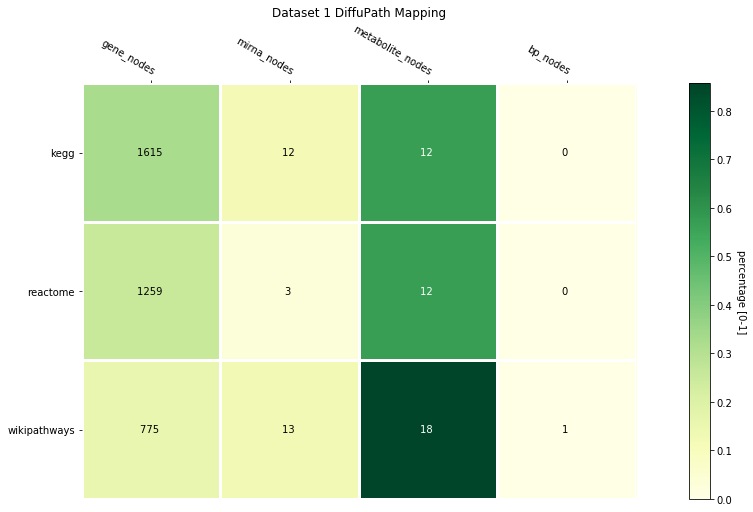

In [36]:
show_heatmap(entity_number, entity_count, databases, entity_types)

In [37]:
from diffupy.utils import get_three_venn_intersections
db_intersections = get_three_venn_intersections(mapping_by_db['kegg'][0], mapping_by_db['reactome'][0], mapping_by_db['wikipathways'][0])



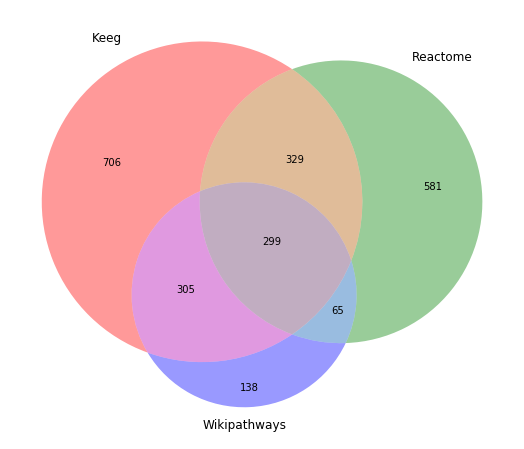

In [38]:
from diffupy.views import show_venn_diagram

show_venn_diagram(db_intersections)

In [39]:
from diffupy.utils import random_disjoint_intersection_three_subsets
disjoint_db_mapping = random_disjoint_intersection_three_subsets(mapping_by_db)


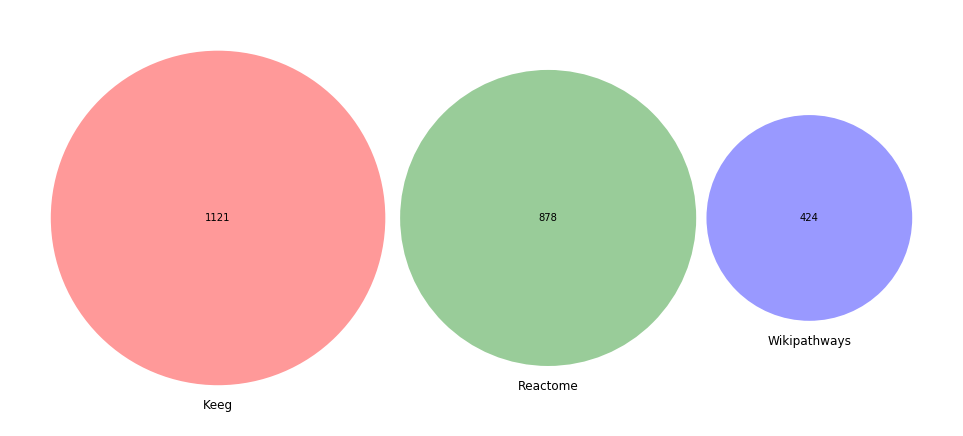

In [40]:
show_venn_diagram(get_three_venn_intersections(*list(disjoint_db_mapping.values())))


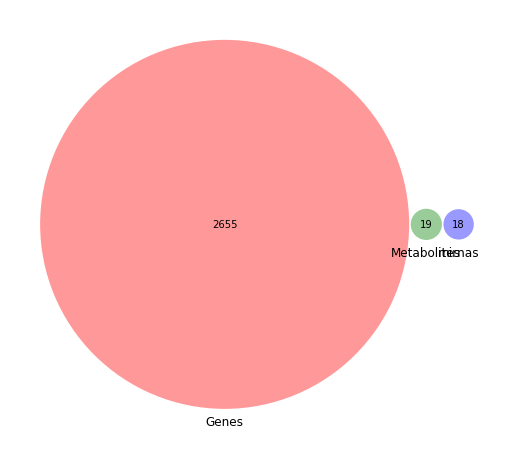

In [41]:
show_venn_diagram(get_three_venn_intersections(*(i[0] for i in mapping_by_entity.values())), 
                  set_labels = ('Genes', 'Metabolites', 'mirnas'))


In [42]:
len(mapping_by_entity['genes'][0])

2655

## 5. Cross-validation

In [43]:
from diffupy.views import box_plot_from_dict
from diffupy.cross_validation import cross_validation_by_method, cross_validation_by_method, cross_validation_one_x_in, cross_validation_by_subset_same_diff_input



### 5.1. Random-validation Scheme

In [43]:
auroc_metrics_by_method, auprc_metrics_by_method = cross_validation_by_method(all_labels_mapping, pathme_universe_graph_no_flatten, background_mat, k = 4)



100%|██████████| 4/4 [59:23<00:00, 850.78s/it]


In [44]:
box_plot_from_dict(auroc_metrics_by_method, 'Random Cross Validation', 'Method type', 'AUROC')

/usr/local/Cellar/ipython/7.2.0/libexec/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [46]:
box_plot_from_dict(auprc_metrics_by_method, 'Random Cross Validation', 'Method type', 'AUPRC')

In [52]:
import json

with open('metrics_set1.txt', 'w') as outfile:  
    json.dump({'auroc_metrics_by_method': auroc_metrics_by_method, 'auprc_metrics_by_method': auprc_metrics_by_method}, outfile)

    

#### 5.1.2.  By entity

In [44]:
auroc_metrics_by_entity, auprc_metrics_by_entity = cross_validation_by_subset_same_diff_input(mapping_by_entity, background_mat, k = 4)


100%|██████████| 4/4 [33:34<00:00, 501.92s/it]


In [45]:
box_plot_from_dict(auroc_metrics_by_entity, 'Random Cross Validation', 'Entity type', 'AUROC')


/usr/local/Cellar/ipython/7.2.0/libexec/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [47]:
box_plot_from_dict(auprc_metrics_by_entity, 'Random Cross Validation', 'Entity type', 'AUPRC')

In [48]:
import json

with open('metrics_set1_by_entity.txt', 'w') as outfile:  
    json.dump({'auroc_metrics_by_entity': auroc_metrics_by_entity, 'auprc_metrics_by_entity': auprc_metrics_by_entity}, outfile)


### 5.2. Leave Two DB Out (LTOO)

In [ ]:
mapping_by_db

In [ ]:
auroc_metrics_by_db, auprc_metrics_by_db = cross_validation_one_x_in_disjoint(mapping_by_db,
                                                                              disjoint = True,
                                                                              background_mat, 
                                                                              k = 1)

In [ ]:
box_plot_from_dict(auroc_metrics_by_entity, 'Leave Two DB Out Validation', 'DB', 'AUROC')

In [ ]:
auroc_metrics_by_db, auprc_metrics_by_db = cross_validation_one_x_in_disjoint(mapping_by_db, 
                                                                              background_mat, 
                                                                              k = 1)

In [ ]:
box_plot_from_dict(auprc_metrics_by_entity, 'Random Cross Validation', 'Entity type', 'AUPRC')

### 5.3. Leave Two DataBases Out (LTDBO)

In [ ]:
auroc_metrics_by_db, auprc_metrics_by_db = cross_validation_one_x_in(mapping_by_entity, background_mat, k = 1 )

In [ ]:
box_plot_from_dict(auroc_metrics_by_db, 'Leave Two Omics Out Validation', 'Entity type', 'AUPRC')